In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

%load_ext autoreload
%autoreload 2

### Reading lighcurves

In [2]:
path_meta = './data/raw_data/macho/MACHO_dataset.dat'
lcs_src   = './data/raw_data/macho/LCs'

In [3]:
meta_df = pd.read_csv(path_meta)
class_names = list(meta_df['Class'].unique())
meta_df = meta_df.rename(columns={'Unnamed: 0': 'ids'})

In [15]:
%%time
lightcurves, labels, oids = [], [], []
for index, row in meta_df.iterrows():
    file = row['Path'].split('/')[-1]
    lc_path = os.path.join(lcs_src, file)
    lc = pd.read_csv(lc_path)
    
    #Filter
    lc = lc.sort_values('mjd')
    lc = lc.drop_duplicates(keep='first')
    lc = lc[lc['errmag'] < 1]
    
    if lc.shape[0] >= 20:
        mean = np.mean(lc.values, 0)
        std = np.std(lc.values, 0)
        inp_matrix = (lc.values - mean)/std
        lightcurves.append(inp_matrix)
        oids.append(row['ids'])
        labels.append(class_names.index(row['Class']))

CPU times: user 8.87 s, sys: 45.7 ms, total: 8.91 s
Wall time: 8.92 s


In [16]:
lightcurves = np.array(lightcurves)
oids = np.array(oids)
labels = np.array(labels)

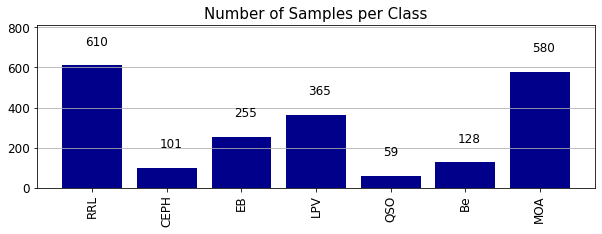

In [17]:
uniques, counts = np.unique(labels, return_counts=True)

LABELS = [class_names[u] for u in uniques]
plt.figure(figsize=(10,3))
plt.bar(uniques, counts, align='center', color='darkblue')

for u, c in zip(uniques, counts):
    plt.text(u-0.1, c+100, '{}'.format(c), fontsize=12)

plt.xticks(uniques, LABELS, rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Samples per Class', fontsize=15)
plt.grid(axis='y')
plt.ylim(0, max(counts)+max(counts)/3)
plt.show()

In [18]:
import pandas as pd
partial = pd.DataFrame(np.vstack([range(len(oids)), labels, oids]).T, 
                       columns = ['index', 'label', 'oid'])
partial.head()

,index,label,oid
0,0,0,0
1,1,0,1
2,2,0,2
3,3,0,3
4,4,0,4


In [19]:
label_groups = partial.groupby('label')
train_frac = 0.5
val_frac = 0.25 # 0.25 for testing


train_df = []
val_df   = []
test_df  = []
for lab, subframe in label_groups:
    # Shuffle
    subframe = subframe.sample(frac=1)
    
    n_train = int(subframe.shape[0] * train_frac)
    n_val = int(subframe.shape[0] * val_frac)
    
    train_frame = subframe.iloc[:n_train, :]
    val_frame   = subframe.iloc[n_train:n_train+n_val, :]
    test_frame  = subframe.iloc[n_train+n_val:, :]
    
    train_df.append(train_frame)
    val_df.append(val_frame)
    test_df.append(test_frame)

train_df = pd.concat(train_df, 0)
val_df   = pd.concat(val_df, 0)
test_df  = pd.concat(test_df, 0)

print('train: {}\nval: {}\ntest:{}'.format(train_df.shape, val_df.shape, test_df.shape))

train: (1047, 3)
val: (522, 3)
test:(529, 3)


/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
/home/ubuntu/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [20]:
subsets = {'train':dict(), 'validation':dict(), 'test':dict()}
subsets['train']['x'] = lightcurves[train_df.index.values]
subsets['train']['y'] = labels[train_df.index.values]
subsets['train']['oid'] = oids[train_df.index.values]

subsets['validation']['x'] = lightcurves[val_df.index.values]
subsets['validation']['y'] = labels[val_df.index.values]
subsets['validation']['oid'] = oids[val_df.index.values]

subsets['test']['x'] = lightcurves[test_df.index.values]
subsets['test']['y'] = labels[test_df.index.values]
subsets['test']['oid'] = oids[test_df.index.values]

In [21]:
from ztf import pad_lightcurves
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%%time
X_train, y_train, m_train, o_train = pad_lightcurves(subsets['train']['x'], 
                                                     subsets['train']['y'], 
                                                     subsets['train']['oid'],
                                                     maxobs=200)
X_valid, y_valid, m_valid, o_valid = pad_lightcurves(subsets['validation']['x'], 
                                                     subsets['validation']['y'], 
                                                     subsets['validation']['oid'],
                                                     maxobs=200)

CPU times: user 280 ms, sys: 28.5 ms, total: 308 ms
Wall time: 308 ms


In [23]:
%%time
maxobs_testing = np.max([x.shape[0] for x in subsets['test']['x']])
X_test, y_test, m_test, o_test = pad_lightcurves(subsets['test']['x'], 
                                                 subsets['test']['y'],
                                                 subsets['test']['oid'],
                                                 maxobs=maxobs_testing)

CPU times: user 74.7 ms, sys: 16.2 ms, total: 90.9 ms
Wall time: 90.2 ms


In [24]:
print('TRAIN: {}  - {}\nVALID: {}  - {}\nTEST:  {} - {}'.format(X_train.shape, y_train.shape,
                                                          X_valid.shape, y_valid.shape,
                                                          X_test.shape, y_test.shape))

TRAIN: (5628, 200, 3)  - (5628,)
VALID: (2837, 200, 3)  - (2837,)
TEST:  (529, 1807, 3) - (529,)


In [25]:
uniques

array([0, 1, 2, 3, 4, 5, 6])

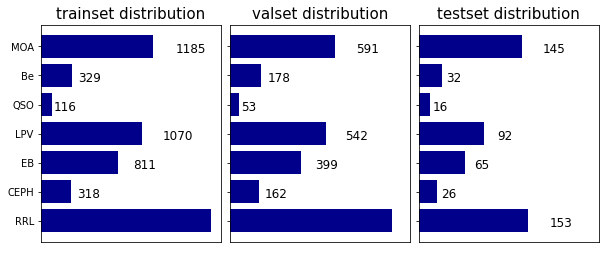

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10,4),sharey=True, 
                        gridspec_kw={'hspace': 0., 'wspace': 0.05},)

for i, (labs, name) in enumerate(zip([y_train, y_valid, y_test], ['train', 'val', 'test'])):
    
    uniques, counts = np.unique(labs, return_counts=True)

    LABELS = [class_names[u] for u in uniques]

    axes[i].barh(uniques, counts, align='center', color='darkblue')

    for u, c in zip(uniques, counts):
        axes[i].text(c+c/5, u-0.2, '{}'.format(c), fontsize=12)
    
    x_ticks = range(len(uniques))
    axes[i].set_yticks(x_ticks)
    axes[i].set_yticklabels(LABELS)

    axes[i].set_title('{}set distribution'.format(name), fontsize=15)
    axes[i].set_xticks([])
    axes[i].set_xlim(0, max(counts)+100)
    
plt.show()

### Writting Records

In [27]:
from data import create_record

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
create_record(light_curves=X_train, 
              labels=y_train, 
              masks=m_train, 
              oids=o_train, 
              path='./data/records/macho/train')

In [29]:
create_record(light_curves=X_valid, 
              labels=y_valid, 
              masks=m_valid, 
              oids=o_valid, 
              path='./data/records/macho/val')

In [30]:
create_record(light_curves=X_test, 
              labels=y_test, 
              masks=m_test, 
              oids=o_test, 
              path='./data/records/macho/test')

### Reading Records

In [31]:
from data import load_record
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
dataset = load_record('./data/records/macho/train', batch_size=32, take=1)

[INFO] Taking 1 balanced batches


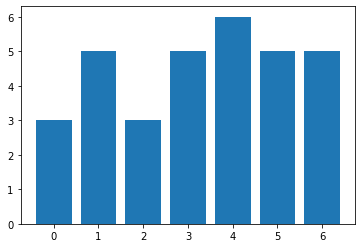

In [35]:
for x, y, m in dataset:    
    y_int = np.argmax(y, 1)
    unique, counts = np.unique(y_int, return_counts=True)
    x_range = range(len(unique))
    plt.bar(x_range, counts)
    plt.xticks(x_range, unique)
    break